In [1]:
import h5py
from glob import glob
import numpy as np
from datetime import datetime

import pandas as pd
import xarray as xr

from dask import array as da
from dask import delayed

from iwaves.utils import isw

import matplotlib.pyplot as plt
from tqdm import tqdm # progress bar

%matplotlib inline
plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'axes.labelsize':'large'})


In [21]:
# Load the converted data
#ds = xr.open_dataset('../../kdv_solutions_azure/kdv_all_ensembles.nc')
ds = xr.open_dataset('../output/kdv_all_ensembles_magnus.nc')

ds

<xarray.Dataset>
Dimensions:   (ensemble: 500, params: 6, time: 1473)
Coordinates:
  * time      (time) int64 0 1 2 3 4 5 6 ... 1466 1467 1468 1469 1470 1471 1472
  * ensemble  (ensemble) int64 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * params    (params) int64 0 1 2 3 4 5
Data variables:
    amax      (ensemble, time) float64 ...
    a0        (ensemble, time) float64 ...
    cn        (ensemble, time) float64 ...
    alpha     (ensemble, time) float64 ...
    beta      (time, ensemble, params) float64 ...
    ubed      (ensemble, time) float64 ...
    usurf     (ensemble, time) float64 ...

In [22]:
ds.amax.max(), ds.amax.min()

(<xarray.DataArray 'amax' ()>
 array(100.736416), <xarray.DataArray 'amax' ()>
 array(-37.636972))

In [23]:
amax_min = ds.amax.min(axis=0)
amax_max = ds.amax.max(axis=0)
amax_50 = np.mean(ds.amax, axis=0)


a0_min = ds.a0.min(axis=0)
a0_max = ds.a0.max(axis=0)
a0_50 = np.mean(ds.a0, axis=0)




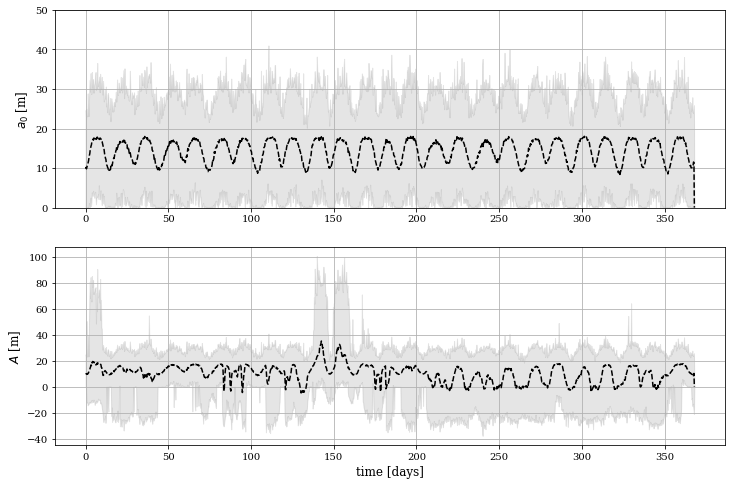

In [24]:
time = ds.time / 4

plt.figure(figsize=(12,8))
plt.subplot(211)
plt.fill_between(time, a0_min, a0_max, color='0.5',alpha=0.2)
plt.plot(time,a0_50,'k--', lw=1.5)
#plt.xlim(200,300)
plt.ylabel('$a_0$ [m]')
plt.ylim(0,50)
#plt.xlabel('time [days]')
plt.grid(b=True)

plt.subplot(212)
plt.fill_between(time, amax_min, amax_max, color='0.5',alpha=0.2)
plt.plot(time,amax_50,'k--', lw=1.5)

#plt.xlim(200,300)
plt.ylabel('$A$ [m]')
plt.xlabel('time [days]')
plt.grid(b=True)

plt.savefig('../FIGURES/kdv_12month_a0_A.png',dpi=150)
plt.show()

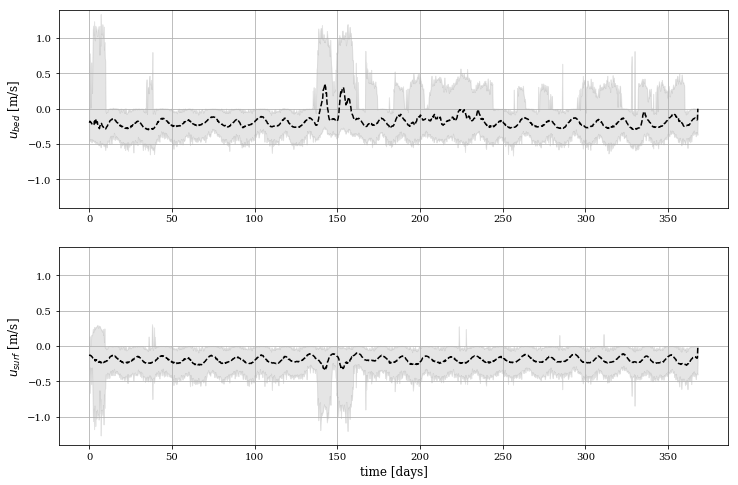

In [25]:

ubed_min = ds.ubed.min(axis=0)
ubed_max = ds.ubed.max(axis=0)
ubed_50 = np.mean(ds.ubed, axis=0)


usurf_min = ds.usurf.min(axis=0)
usurf_max = ds.usurf.max(axis=0)
usurf_50 = np.mean(ds.usurf, axis=0)

plt.figure(figsize=(12,8))
plt.subplot(211)
plt.fill_between(time, ubed_min, ubed_max, color='0.5',alpha=0.2)
plt.plot(time,ubed_50,'k--', lw=1.5)
#plt.xlim(200,300)
plt.ylabel('$u_{bed}$ [m/s]')
plt.ylim(-1.4,1.4)
#plt.xlabel('time [days]')
plt.grid(b=True)

plt.subplot(212)
plt.fill_between(time, usurf_min, usurf_max, color='0.5',alpha=0.2)
plt.plot(time,usurf_50,'k--', lw=1.5)
#plt.xlim(200,300)
plt.ylabel('$u_{surf}$ [m/s]')
plt.ylim(-1.4,1.4)

plt.xlabel('time [days]')
plt.grid(b=True)

plt.savefig('../FIGURES/kdv_12month_velocity.png',dpi=150)
plt.show()

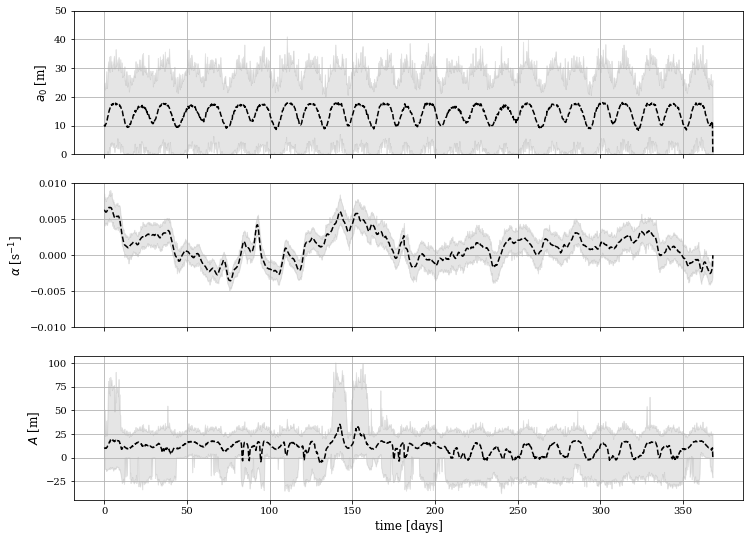

In [26]:
alpha_min = ds.alpha.min(axis=0)
alpha_max = ds.alpha.max(axis=0)
alpha_50 = np.median(ds.alpha, axis=0)


time = ds.time / 4

plt.figure(figsize=(12,9))
ax1=plt.subplot(311)
plt.fill_between(time, a0_min, a0_max, color='0.5',alpha=0.2)
plt.plot(time,a0_50,'k--', lw=1.5)
#plt.xlim(200,300)
plt.ylabel('$a_0$ [m]')
plt.ylim(0,50)
ax1.set_xticklabels([])

#plt.xlabel('time [days]')
plt.grid(b=True)

ax2=plt.subplot(312)
plt.fill_between(time, alpha_min, alpha_max, color='0.5',alpha=0.2)
plt.plot(time,alpha_50,'k--', lw=1.5)
#plt.xlim(200,300)
plt.ylabel(r'$\alpha$ [s$^{-1}$]')
plt.ylim(-0.01,0.01)
ax2.set_xticklabels([])
#plt.xlabel('time [days]')
plt.grid(b=True)

ax3=plt.subplot(313)
plt.fill_between(time, amax_min, amax_max, color='0.5',alpha=0.2)
plt.plot(time,amax_50,'k--', lw=1.5)

#plt.xlim(200,300)
plt.ylabel('$A$ [m]')
plt.xlabel('time [days]')
plt.grid(b=True)

plt.savefig('../FIGURES/kdv_12month_a0_A_alpha.png',dpi=150)

plt.show()

In [8]:
T = 12.42*3600.
omega = 2*np.pi / T
Ls = ds.cn**2. / (np.abs(ds.alpha)*ds.a0*omega) 
L = 0.75e5



/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


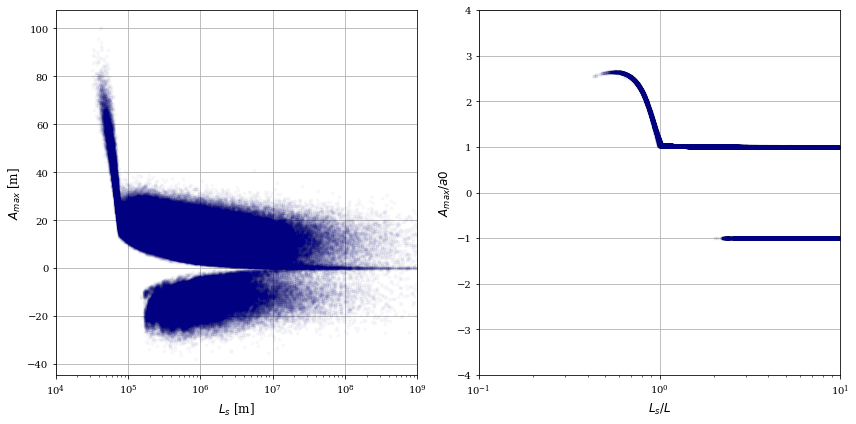

In [9]:
plt.figure(figsize=(12,6))

plt.subplot(121)
plt.semilogx(Ls, ds.amax, '.', color='navy', alpha=0.02)
plt.xlim(1e4,1e9)
#plt.ylim(-4,4)
plt.grid(b=True)

plt.ylabel(r'$A_{max}$ [m]')
plt.xlabel('$L_s$ [m]')

plt.subplot(122)
plt.semilogx(Ls/L, ds.amax/ds.a0, '.', color='navy', alpha=0.02)
plt.xlim(1e-1,10)
plt.ylim(-4,4)
plt.grid(b=True)

plt.ylabel(r'$A_{max}/a0$')
plt.xlabel('$L_s / L$')


plt.tight_layout()

plt.savefig('../FIGURES/kdv_Amax_vs_Ls.png',dpi=150)
